# Credit Risk Modeling
Financial firms use credit risk modeling, a mathematical technique, to determine the probability that a borrower will miss payments on a loan or otherwise fail to fulfill their credit obligations. Credit risk modeling uses statistical methods and predictive analytics to assist lenders in making well-informed decisions on lending, interest rate setting, and portfolio risk management. The goal is to enhance risk management strategies and optimize the allocation of resources in the lending process.

On this data, there are many columns describe the details of the loan transaction in the lending company. The information we can get from the columns is such as loan amount, term of the loan, grade of the borrower, and many more. The latest transaction status can be accessed in `loan_status` column which will be the target of the model we will develop. This model aims to predict whether borrowers will be likely to be able to repay the loans they apply for or will default. From this perspective, we can get the analytical approach questions for end-to-end credit risk modeling like:
- How do you approach data cleaning and preprocessing for credit risk modeling?
- What are the important variables you would consider in a credit risk dataset, and how would you deal with missing data?
- How would you address the class imbalance in the dataset when selecting a credit risk model?
- How do you compare the pros and cons of the machine learning models you will use for the credit risk modeling?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("loan_data_2007_2014.csv", low_memory = False)

## Data & Business Understanding
In this section, we will understand the variables contained in the available data by understanding the context of these variables from the data dictionary. After that, we will also try to understand the business processes of lending companies, especially the loan application operation until repayment. Understanding business processes is needed to align them with available data. In this way, we can determine the variables that are relevant to the objectives of the model to be developed. The following is the business process flow for applying for a loan in general.
<img align ="middle" width=750 height=525 src="https://www.researchgate.net/profile/Sarandis-Mitropoulos/publication/341152094/figure/fig2/AS:1024709135196160@1621321104415/The-flowchart-of-the-proposed-digital-loan-cycle.jpg">
Source: https://www.researchgate.net/publication/341152094_An_integrated_approach_for_the_banking_intranetextranet_information_systems_the_interoperability_case

The loan application process begins with the Loan Application process. After that, the client will be checked whether it is registered or not. Loan Applications from registered Clients will proceed to the Application Assessment process. This process will determine whether the Loan Application will be Approved or Rejected. If we look at this process, this process is the objective of the Credit Risk Model that will be developed. Therefore, the data obtained from the Loan Application and Client will be used by the Credit Risk Model to determine whether the Client is most likely to be able to repay the loan or not.

After the loan application has been assessed, the process will continue to Application Signing. If the Application Signing is approved by both parties, then the next process is Loan Disbursement. After this process, there will be a loan transaction process until the Client makes full repayment which is in the Loan Repayment process. This process will produce data related to the client's loan repayment processes. Of course, this data can only be obtained when the debt transaction process is underway with the Client. Therefore, using data from this process for Credit Risk Modeling is an inappropriate decision and may not be relevant. This is because the Credit Risk Model will be used in the previous process, specifically Loan Assessment.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

As we can see in the structure of the data above, there a columns that only have NaN value. We don't need that columns for analysis or modeling so we can drop that column.
- Remove index column
- Remove column that only have NaN/missing values

In [4]:
df = df.drop(columns = ['Unnamed: 0'])
df = df.dropna(axis=1, how='all')

### Data Dictionary
Below is a data dictionary of this lending data which can help us to understand the context of each variable in the data. There are several variables that may be obtained in the Loan Repayment process. These variables are highlighted in bold along with other irrelevant variables such as id, member_id, and url.

| LoanStatNew                 | Description                                                                                                                                                                                                        |
| :-------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **id**                          | A unique LC assigned ID for the loan listing.                                                                                                                                                                      |
| **member_id**                   | A unique LC assigned Id for the borrower member.                                                                                                                                                                   |
| loan_amnt                   | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.                                       |
| funded_amnt                 | The total amount committed to that loan at that point in time.                                                                                                                                                     |
| funded_amnt_inv             | The total amount committed by investors for that loan at that point in time.                                                                                                                                       |
| term                        | The number of payments on the loan. Values are in months and can be either 36 or 60.                                                                                                                               |
| int_rate                    | Interest Rate on the loan                                                                                                                                                                                          |
| installment                 | The monthly payment owed by the borrower if the loan originates.                                                                                                                                                   |
| grade                       | LC assigned loan grade                                                                                                                                                                                             |
| sub_grade                   | LC assigned loan subgrade                                                                                                                                                                                          |
| emp_title                   | The job title supplied by the Borrower when applying for the loan.\*                                                                                                                                               |
| emp_length                  | Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.                                                                                  |
| home_ownership              | The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.                                                                                                |
| annual_inc                  | The self-reported annual income provided by the borrower during registration.                                                                                                                                      |
| verification_status         | Indicates if income was verified by LC, not verified, or if the income source was verified                                                                                                                         |
| **issue_d**                     | The month which the loan was funded                                                                                                                                                                                |
| loan_status                 | Current status of the loan                                                                                                                                                                                         |
| pymnt_plan                  | Indicates if a payment plan has been put in place for the loan                                                                                                                                                     |
| **url**                         | URL for the LC page with listing data.                                                                                                                                                                             |
| desc                        | Loan description provided by the borrower                                                                                                                                                                          |
| purpose                     | A category provided by the borrower for the loan request.                                                                                                                                                          |
| title                       | The loan title provided by the borrower                                                                                                                                                                            |
| zip_code                    | The first 3 numbers of the zip code provided by the borrower in the loan application.                                                                                                                              |
| addr_state                  | The state provided by the borrower in the loan application                                                                                                                                                         |
| dti                         | A ratio calculated using the borrower's total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower's self-reported monthly income.           |
| **delinq_2yrs**                 | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years                                                                                                       |
| earliest_cr_line            | The month the borrower's earliest reported credit line was opened                                                                                                                                                  |
| **inq_last_6mths**              | The number of inquiries in past 6 months (excluding auto and mortgage inquiries)                                                                                                                                   |
| **mths_since_last_delinq**      | The number of months since the borrower's last delinquency.                                                                                                                                                        |
| **mths_since_last_record**      | The number of months since the last public record.                                                                                                                                                                 |
| open_acc                    | The number of open credit lines in the borrower's credit file.                                                                                                                                                     |
| pub_rec                     | Number of derogatory public records                                                                                                                                                                                |
| revol_bal                   | Total credit revolving balance                                                                                                                                                                                     |
| revol_util                  | Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.                                                                                         |
| total_acc                   | The total number of credit lines currently in the borrower's credit file                                                                                                                                           |
| initial_list_status         | The initial listing status of the loan. Possible values are – Whole, Fractional                                                                                                                                    |
| **out_prncp**                   | Remaining outstanding principal for total amount funded                                                                                                                                                            |
| **out_prncp_inv**               | Remaining outstanding principal for portion of total amount funded by investors                                                                                                                                    |
| **total_pymnt**                 | Payments received to date for total amount funded                                                                                                                                                                  |
| **total_pymnt_inv**             | Payments received to date for portion of total amount funded by investors                                                                                                                                          |
| **total_rec_prncp**             | Principal received to date                                                                                                                                                                                         |
| **total_rec_int**               | Interest received to date                                                                                                                                                                                          |
| **total_rec_late_fee**          | Late fees received to date                                                                                                                                                                                         |
| **recoveries**                  | post charge off gross recovery                                                                                                                                                                                     |
| **collection_recovery_fee**     | post charge off collection fee                                                                                                                                                                                     |
| **last_pymnt_d**                | Last month payment was received                                                                                                                                                                                    |
| **last_pymnt_amnt**             | Last total payment amount received                                                                                                                                                                                 |
| **next_pymnt_d**                | Next scheduled payment date                                                                                                                                                                                        |
| **last_credit_pull_d**          | The most recent month LC pulled credit for this loan                                                                                                                                                               |
| **collections_12_mths_ex_med**  | Number of collections in 12 months excluding medical collections                                                                                                                                                   |
| **mths_since_last_major_derog** | Months since most recent 90-day or worse rating                                                                                                                                                                    |
| policy_code                 | publicly available policy_code=1 new products not publicly available policy_code=2                                                                                                                                 |
| application_type            | Indicates whether the loan is an individual application or a joint application with two co-borrower's                                                                                                              |
| acc_now_delinq              | The number of accounts on which the borrower is now delinquent.                                                                                                                                                    |
| **tot_coll_amt**                | Total collection amounts ever owed                                                                                                                                                                                 |
| **tot_cur_bal**                 | Total current balance of all accounts                                                                                                                                                                              |
| **total_rev_hi_lim**            | Total revolving high credit/credit limit                                                                                                                                                                           |

In [5]:
irrelevant_features = ['id', 'member_id', 'issue_d', 'url', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
                       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
                       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
                       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
df = df.drop(irrelevant_features, axis=1)

## Exploratory Data Analysis
Aim to understand the general pattern of data such as shape of data, variables or feature, and type of data using descriptive analytics and data visualization. Exploratory Data Analysis can be started by analyzing the target of this model, namely loan status and relationships with other variables. After that, we can also analyze the relationship between variables in the dataset.
#### Loan Status (Target)

In [6]:
df['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In the `loan_status` column, there are several loan statuses which generally consist of Fully Paid, Late, Default, In Grace Period, and Does not meet the credit policy.

In [7]:
target_classes = ['Fully Paid', 'Charged Off', 'Default']
df = df[df['loan_status'].isin(target_classes)]

([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

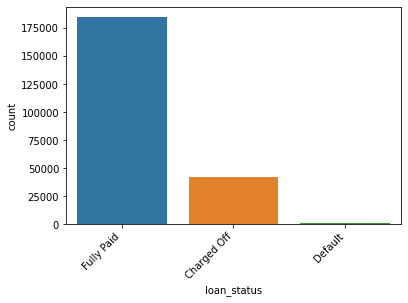

In [8]:
count_plot = sns.countplot(df, x='loan_status', hue='loan_status')
plt.xticks(rotation=45, horizontalalignment='right')

The `Charged Off` and `Default` class are actually the same situation. We can combine the `Default` and `Charged Off` classes into `Charged Off`

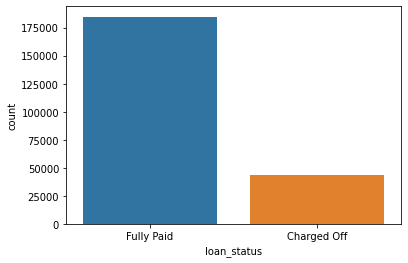

In [9]:
df['loan_status'] = np.where(df['loan_status'] == "Default", "Charged Off",
                             df['loan_status'])
count_plot = sns.countplot(df, x='loan_status', hue='loan_status')

### Numeric Variables
To analyze numerical variables, we can carry out correlation analysis to see whether there are redundant variables or not. We can also see whether there are variables that are correlated with other variables so that they are not independent.

<AxesSubplot:>

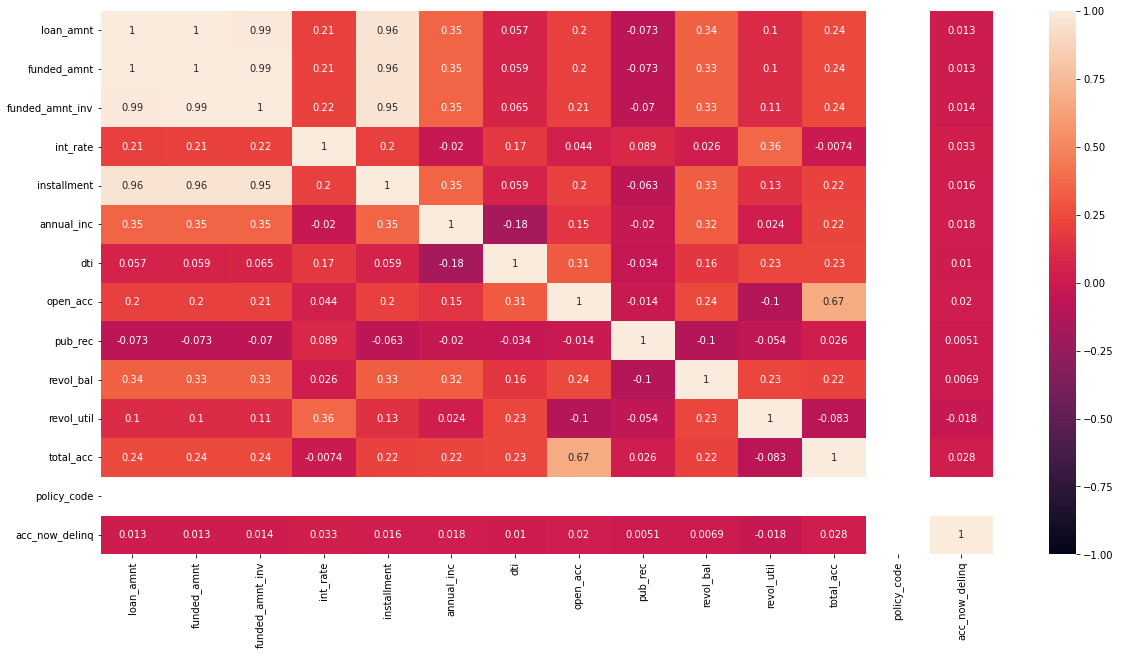

In [10]:
plt.subplots(figsize=(20,10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

We can see that the variables `loan_amnt`, `funded_amnt`, and `funded_amnt_inv` have perfect correlation values. This clearly indicates that these variables are redundant. We can just use the `loan_amnt` variable because based on the available data dictionary, if there is a change in the loan amount it will be reflected in this variable. Apart from that, there are also variables that only have one value in them, namely `policy_code`, this causes this variable to be irrelevant in having a correlation with other variables.

In [11]:
df = df.drop(['funded_amnt', 'funded_amnt_inv', 'policy_code'], axis=1)

Furthermore, there are variables that have a fairly high correlation, namely `loan_amnt` with `installment`. We will explore these variables to see if there is duplicate information in them and their correlation with the target variable.
#### loan_amnt and installment
- loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- installment: The monthly payment owed by the borrower if the loan originates.

<AxesSubplot:xlabel='loan_status', ylabel='installment'>

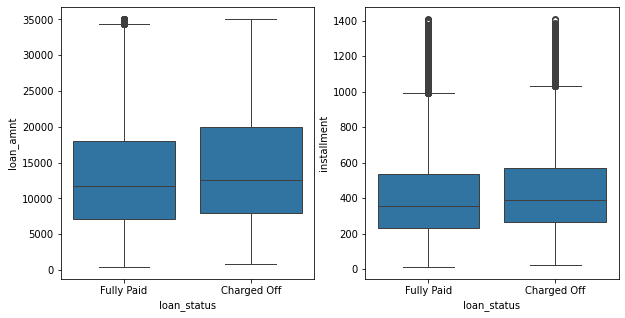

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(x='loan_status',y='loan_amnt', data=df, ax=axs[0])
sns.boxplot(x='loan_status',y='installment', data=df, ax=axs[1])

<AxesSubplot:xlabel='installment', ylabel='Count'>

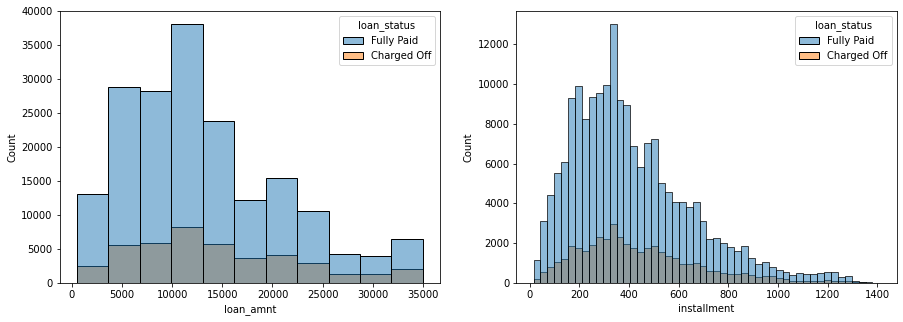

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(data=df, x="loan_amnt", hue="loan_status", bins=11, ax=axs[0])
sns.histplot(data=df, x="installment", hue="loan_status", bins=50, ax=axs[1])

If we look at the distribution of these two variables, it does not appear that there is redundant information because `installment` is information on the amount that must be paid by the client each month based on `loan_amnt`, `term`, and `int_rate`. So, we can still use these two variables so that the model has good interpretability since `installment` is related to loan characteristics. This variable can also be a consideration for experimenting with the model if the model results are less than satisfactory.

### Categorical Variables

In [14]:
df.select_dtypes(include=object).nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              125310
emp_length                 11
home_ownership              6
verification_status         3
loan_status                 2
pymnt_plan                  2
desc                    87760
purpose                    14
title                   47943
zip_code                  870
addr_state                 50
earliest_cr_line          633
initial_list_status         2
application_type            1
dtype: int64

In [15]:
# drop application_type because only have one unique value
df = df.drop(['application_type'], axis=1)

#### emp_title
We can see that the `emp_title` variable has a lot of unique values. Too many categories can cause confusion when model doing the training.

In [16]:
df['emp_title'].head(10)

0                       NaN
1                     Ryder
2                       NaN
3       AIR RESOURCES BOARD
5      Veolia Transportaton
7           MKC Accounting 
8                       NaN
9                 Starbucks
10    Southwest Rural metro
11                     UCLA
Name: emp_title, dtype: object

In [17]:
df['emp_title'].isna().sum()

12758

In [18]:
df = df.drop(['emp_title'], axis=1)

#### desc, purpose, and title

In [19]:
df[['desc', 'purpose', 'title']].head(10)

,desc,purpose,title
0,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer
1,Borrower added on 12/22/11 > I plan to use t...,car,bike
2,NaN,small_business,real estate business
3,Borrower added on 12/21/11 > to pay for prop...,other,personel
5,NaN,wedding,My wedding loan I promise to pay back
7,Borrower added on 12/16/11 > Downpayment for...,car,Car Downpayment
8,Borrower added on 12/21/11 > I own a small h...,small_business,Expand Business & Buy Debt Portfolio
9,Borrower added on 12/16/11 > I'm trying to b...,other,Building my credit history.
10,Borrower added on 12/15/11 > I had recived a...,debt_consolidation,High intrest Consolidation
11,NaN,debt_consolidation,Consolidation


If we look at the `desc` feature, there is quite a large proportion of descriptions that are blank. So we will try to extract this feature into is `desc` have NaN value.

In [20]:
df['desc_is_na'] = df['desc'].isna()

<AxesSubplot:xlabel='desc_is_na'>

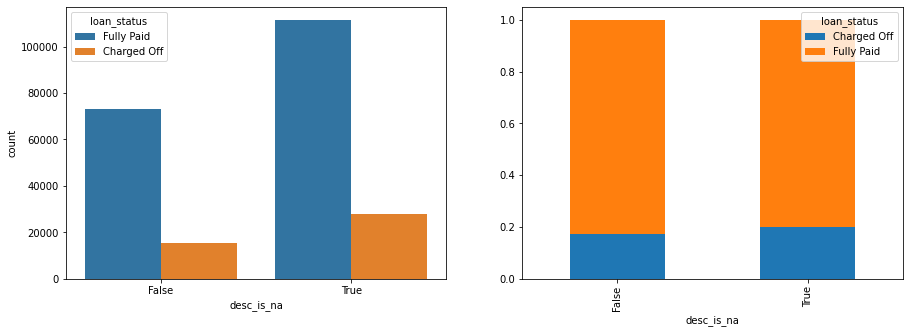

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
sns.countplot(df, x='desc_is_na', hue='loan_status', ax=axs[0])
df.groupby('desc_is_na')['loan_status'].value_counts(normalize=True).unstack('loan_status').plot.bar(stacked=True, ax=axs[1])

If you look at the 100% count plot above, the descriptions that filled have a slightly higher proportion of fully paid loan status. So we will extract the feature into `desc_is_na` and drop `desc`

In [22]:
df = df.drop('desc', axis=1)

In [23]:
df[['title', 'purpose']].value_counts()[:10]

title                    purpose           
Debt consolidation       debt_consolidation    56184
Credit card refinancing  credit_card           18339
Debt Consolidation       debt_consolidation    10378
Home improvement         home_improvement       4975
Other                    other                  4602
debt consolidation       debt_consolidation     3041
Consolidation            debt_consolidation     3038
Debt Consolidation Loan  debt_consolidation     2956
Major purchase           major_purchase         1614
Business                 small_business         1466
dtype: int64

If we look at the results of the value counts above, the `purpose` feature is definitely generated from the `title`. So the `title` is a redundant feature of features that have been summarized into `purpose`.

In [24]:
df = df.drop('title', axis=1)

#### zip_code and addr_state

In [25]:
df[['zip_code', 'addr_state']].head(5)

,zip_code,addr_state
0,860xx,AZ
1,309xx,GA
2,606xx,IL
3,917xx,CA
5,852xx,AZ


In [26]:
df[['zip_code', 'addr_state']].value_counts()[:10]

zip_code  addr_state
945xx     CA            2958
112xx     NY            2629
750xx     TX            2503
100xx     NY            2329
900xx     CA            2270
606xx     IL            2243
331xx     FL            2066
300xx     GA            2044
070xx     NJ            2014
917xx     CA            1901
dtype: int64

<AxesSubplot:xlabel='addr_state'>

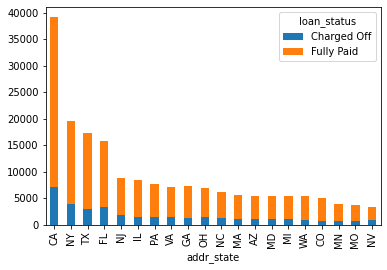

In [27]:
top_20_state = ['CA', 'NY', 'TX', 'FL', 'NJ', 'IL', 'PA', 'VA', 'GA', 'OH',
                'NC', 'MA', 'AZ', 'MD', 'MI', 'WA', 'CO', 'MN', 'MO', 'NV']
df_plot = df[df['addr_state'].isin(top_20_state)]
df_plot = df_plot.groupby(['loan_status', 'addr_state']).size().reset_index().pivot(columns='loan_status', index='addr_state', values=0)
df_plot.loc[top_20_state].plot(kind='bar', stacked=True)

We know that the first 3 numbers of the zip code represent the sectional center and state information is in the first group of numbers in the zip code. So there are redundant information between these variables, addr_state only specifies the state of the first 3 digits of the zip code.

In [28]:
df = df.drop('zip_code', axis=1)

#### earliest_cr_line

In [29]:
df['earliest_cr_line'].head(10)

0     Jan-85
1     Apr-99
2     Nov-01
3     Feb-96
5     Nov-04
7     Jan-07
8     Apr-04
9     Sep-04
10    Jan-98
11    Oct-89
Name: earliest_cr_line, dtype: object

In [30]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['earliest_cr_line'].describe(datetime_is_numeric=True)

count                           228046
mean     1998-03-07 18:37:13.633565184
min                1969-01-01 00:00:00
25%                1994-09-01 00:00:00
50%                1999-05-01 00:00:00
75%                2002-09-01 00:00:00
max                2068-12-01 00:00:00
Name: earliest_cr_line, dtype: object

In [31]:
import datetime

def fix_date(x):
    if x.year > 2030:
        year = x.year - 100
    else:
        year = x.year
    return datetime.date(year,x.month,x.day)

df['earliest_cr_line'] = df['earliest_cr_line'].apply(fix_date)

In [32]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

In [33]:
df['earliest_cr_line'].describe(datetime_is_numeric=True)

count                           228046
mean     1997-12-18 23:23:29.368285568
min                1946-01-01 00:00:00
25%                1994-08-01 00:00:00
50%                1999-05-01 00:00:00
75%                2002-09-01 00:00:00
max                2011-11-01 00:00:00
Name: earliest_cr_line, dtype: object

<AxesSubplot:xlabel='earliest_cr_line', ylabel='Count'>

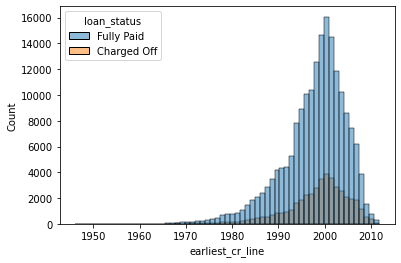

In [34]:
sns.histplot(data=df, x="earliest_cr_line", hue="loan_status", bins=61)

In [35]:
df['earliest_cr_line'] = pd.DatetimeIndex(df['earliest_cr_line']).year

#### grade and sub_grade

In [36]:
print(df['grade'].unique())
print(df['sub_grade'].unique())

['B' 'C' 'A' 'E' 'F' 'D' 'G']
['B2' 'C4' 'C5' 'C1' 'A4' 'E1' 'F2' 'B5' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F1' 'E5' 'G4'
 'E2' 'G2' 'G1' 'F5' 'F4' 'G5' 'G3']


<AxesSubplot:xlabel='sub_grade'>

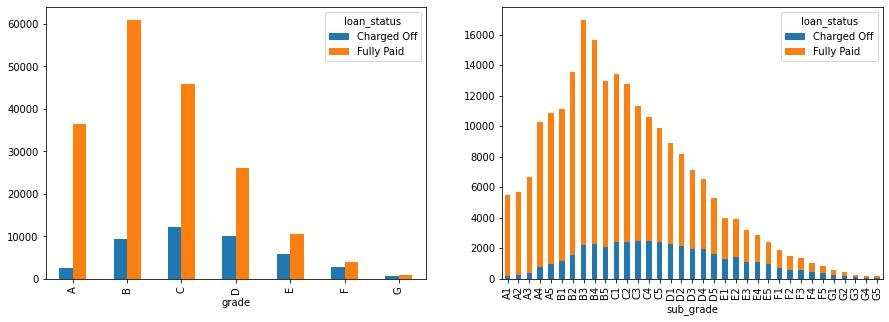

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
pd.crosstab(df['grade'], df['loan_status']).plot(kind='bar', ax=axs[0])
pd.crosstab(df['sub_grade'], df['loan_status']).plot(kind='bar', stacked=True, ax=axs[1])

In [38]:
pd.crosstab(df['grade'], df['loan_status'], normalize='index')\
.round(2)

loan_status,Charged Off,Fully Paid
grade,,
A,0.07,0.93
B,0.13,0.87
C,0.21,0.79
D,0.28,0.72
E,0.36,0.64
F,0.41,0.59
G,0.45,0.55


In [39]:
pd.crosstab(df['sub_grade'], df['loan_status'], normalize='index')\
.round(2)

loan_status,Charged Off,Fully Paid
sub_grade,,
A1,0.03,0.97
A2,0.05,0.95
A3,0.06,0.94
A4,0.07,0.93
A5,0.09,0.91
B1,0.11,0.89
B2,0.12,0.88
B3,0.13,0.87
B4,0.15,0.85


We can see that clients with `grade` E, F, and G have a higher proportion to Charge Off compared to other `grade`. This is also represented in the `sub_grade` feature. We know that each `sub_grade` also represents their `grade`, so we need to drop `grade` features to reduce redundant information.

In [40]:
df = df.drop('grade', axis=1)

## Data Preprocessing
### Handling Missing Data

In [41]:
for column in df.columns:
    if df[column].isna().sum() != 0:
        missing = df[column].isna().sum()
        missing_prob = (missing / df.shape[0]) * 100
        print(f"{column}: {missing}({missing_prob:.2f}%)")

emp_length: 8721(3.82%)
revol_util: 186(0.08%)


#### emp_length

In [42]:
pd.crosstab(df['emp_length'], df['loan_status'], normalize='index')\
.round(2)

loan_status,Charged Off,Fully Paid
emp_length,,
1 year,0.18,0.82
10+ years,0.18,0.82
2 years,0.18,0.82
3 years,0.18,0.82
4 years,0.18,0.82
5 years,0.19,0.81
6 years,0.19,0.81
7 years,0.19,0.81
8 years,0.20,0.80


We can see that the proportion of `loan_status` between `emp_length` are very similar. Before we decide to drop this column or not, we need to see the composition of `emp_length` which has the value NaN.

In [43]:
df[df['emp_length'].isnull()]['loan_status'].value_counts()

Fully Paid     6351
Charged Off    2370
Name: loan_status, dtype: int64

The `emp_length` that has the NaN value also contains a lot of information from that client Charge Off. So we cannot simply delete rows that have an emp_length value of NaN because it will reduce a lot of information from Charge Off clients.

In [44]:
df = df.drop('emp_length', axis=1)

#### revol_util
- Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [45]:
df[df['revol_util'].isnull()]['loan_status'].value_counts()

Fully Paid     139
Charged Off     47
Name: loan_status, dtype: int64

Relative to the data size, the amount of data in the `revol_util` column that has NaN values is quite small. So we can delete rows that `revol_util` have NaN values

In [46]:
df = df[df['revol_util'].notnull()]

### Convert Numeric Variables

In [47]:
df.select_dtypes(include=np.number).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227860 entries, 0 to 466283
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_amnt         227860 non-null  int64  
 1   int_rate          227860 non-null  float64
 2   installment       227860 non-null  float64
 3   annual_inc        227860 non-null  float64
 4   dti               227860 non-null  float64
 5   earliest_cr_line  227860 non-null  int64  
 6   open_acc          227860 non-null  float64
 7   pub_rec           227860 non-null  float64
 8   revol_bal         227860 non-null  int64  
 9   revol_util        227860 non-null  float64
 10  total_acc         227860 non-null  float64
 11  acc_now_delinq    227860 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 22.6 MB


In [48]:
df.select_dtypes(include=bool).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227860 entries, 0 to 466283
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   desc_is_na  227860 non-null  bool 
dtypes: bool(1)
memory usage: 2.0 MB


In [49]:
col_to_int = ['open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq']
col_to_float = ['revol_bal', 'loan_amnt', 'desc_is_na']

df[col_to_int] = df[col_to_int].astype(int)
df[col_to_float] = df[col_to_float].astype(float)

### Removing Outliers

In [50]:
cols = df.select_dtypes(float).columns
df_sub = df.loc[:, cols]

lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 3

df.loc[:, cols] = df_sub.where(lim, np.nan)

df.dropna(subset=cols, inplace=True)

## Encode Data
### Target

In [51]:
le = LabelEncoder()

In [52]:
df.loan_status = le.fit_transform(df.loan_status)

In [53]:
print(le.transform(['Charged Off', 'Fully Paid']))
print(le.classes_)

[0 1]
['Charged Off' 'Fully Paid']


### Categorical Variables

In [54]:
df.select_dtypes(include=object).head()

,term,sub_grade,home_ownership,verification_status,pymnt_plan,purpose,addr_state,initial_list_status
0,36 months,B2,RENT,Verified,n,credit_card,AZ,f
1,60 months,C4,RENT,Source Verified,n,car,GA,f
2,36 months,C5,RENT,Not Verified,n,small_business,IL,f
3,36 months,C1,RENT,Source Verified,n,other,CA,f
5,36 months,A4,RENT,Source Verified,n,wedding,AZ,f


In [55]:
df['term'] = np.where(df['term'] == " 36 months", 36,
             np.where(df['term'] == " 60 months", 60,         
             df['term']))
df['term'] = df['term'].astype(int)
df['term'].unique()

array([36, 60])

### Create Transformer

In [56]:
categories = df.select_dtypes(include=[object]).columns.tolist()

In [57]:
numerics = df.drop(['loan_status'], axis=1).select_dtypes(include=np.number).columns.tolist()

In [58]:
ohe = OneHotEncoder(sparse_output=False)
scaler = MinMaxScaler()

In [59]:
ct = ColumnTransformer(
    [("onehotencoder", ohe, categories),
     ("minmaxscaler", scaler, numerics)],
    remainder = 'passthrough'
)

ct.set_output(transform='pandas')
processed_df = ct.fit_transform(df.drop(['loan_status'], axis=1))

In [60]:
processed_df = pd.concat([processed_df, df['loan_status']], axis=1)

In [61]:
processed_df.loan_status.value_counts()

1    178416
0     42012
Name: loan_status, dtype: int64

### Train Test Split

In [62]:
train, test = train_test_split(processed_df, test_size=0.2, random_state=42)

In [63]:
print(train.shape)
print(test.shape)

(176342, 127)
(44086, 127)


In [64]:
test.loan_status.value_counts()

1    35803
0     8283
Name: loan_status, dtype: int64

In [65]:
train.loan_status.value_counts()

1    142613
0     33729
Name: loan_status, dtype: int64

In [66]:
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [67]:
print(X_train.shape)
print(y_train.shape)

(176342, 126)
(176342,)


## Model Building
### Random Forest

In [68]:
rf_clf = RandomForestClassifier()

In [69]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [70]:
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

In [71]:
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.9999943292012112
0.8121172254230368


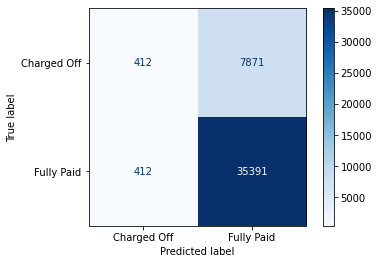

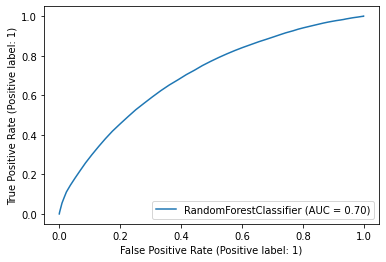

In [72]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Charged Off', 'Fully Paid']
)

disp = RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)

In [73]:
auc_data = [['Random Forest', roc_auc_score(y_train, rf_clf.predict_proba(X_train)[:,1]), roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:,1])]]
df_auc_score = pd.DataFrame(auc_data, columns=['Models', 'AUC_Train', 'AUC_Test'])

### XGBoost

In [74]:
xgb_clf = XGBClassifier(use_label_encoder=False)

In [75]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [76]:
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

In [77]:
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.8253450681062935
0.811754298416731


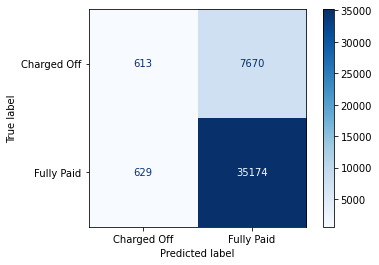

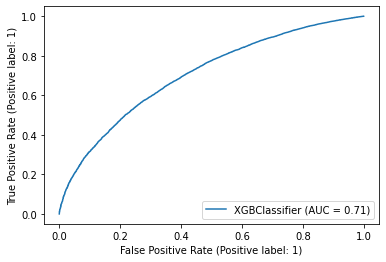

In [78]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Charged Off', 'Fully Paid']
)

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

In [79]:
df_auc_score.loc[1] = ['XGBoost', roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:,1]), roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])]

### Neural Network

In [80]:
ann_clf = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [81]:
ann_clf.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [82]:
history = ann_clf.fit(x=X_train,
                      y=y_train,
                      epochs=10,
                      batch_size=256,
                      validation_data=(X_test, y_test))

Epoch 1/10
689/689 [==============================] - 12s 7ms/step - loss: 0.4603 - binary_accuracy: 0.8082 - val_loss: 0.4427 - val_binary_accuracy: 0.8122
Epoch 2/10
689/689 [==============================] - 4s 6ms/step - loss: 0.4505 - binary_accuracy: 0.8088 - val_loss: 0.4435 - val_binary_accuracy: 0.8133
Epoch 3/10
689/689 [==============================] - 4s 6ms/step - loss: 0.4484 - binary_accuracy: 0.8092 - val_loss: 0.4465 - val_binary_accuracy: 0.8137
Epoch 4/10
689/689 [==============================] - 4s 6ms/step - loss: 0.4464 - binary_accuracy: 0.8093 - val_loss: 0.4428 - val_binary_accuracy: 0.8130
Epoch 5/10
689/689 [==============================] - 4s 6ms/step - loss: 0.4454 - binary_accuracy: 0.8095 - val_loss: 0.4428 - val_binary_accuracy: 0.8123
Epoch 6/10
689/689 [==============================] - 4s 6ms/step - loss: 0.4436 - binary_accuracy: 0.8102 - val_loss: 0.4422 - val_binary_accuracy: 0.8133
Epoch 7/10
689/689 [==============================] - 4s 6ms/st

In [83]:
y_test_pred = (ann_clf.predict(X_test) > 0.5).astype("int32")
print(accuracy_score(y_test, y_test_pred))

0.8127977135598603


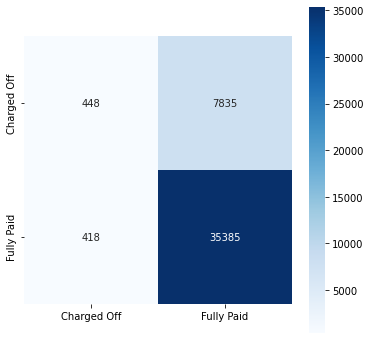

In [84]:
x_axis_labels = ['Charged Off', 'Fully Paid']
y_axis_labels = ['Charged Off', 'Fully Paid']
cm = confusion_matrix(y_test, y_test_pred)
fig, ax =plt.subplots(figsize=(6,6))
f = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels, square=True)

In [85]:
df_auc_score.loc[2] = ['Neural Network', roc_auc_score(y_train, ann_clf.predict(X_train)), roc_auc_score(y_test, ann_clf.predict(X_test))]

In [86]:
df_auc_score[['AUC_Train', 'AUC_Test']] = df_auc_score[['AUC_Train', 'AUC_Test']].round(2)

## Model Comparison

In [87]:
df_auc_score

,Models,AUC_Train,AUC_Test
0,Random Forest,1.00,0.70
1,XGBoost,0.79,0.71
2,Neural Network,0.74,0.70


(0.0, 1.0)

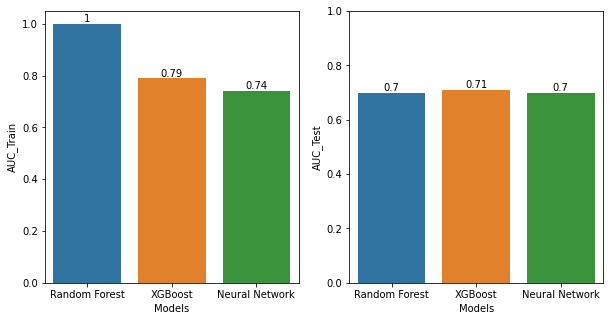

In [88]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax_train = sns.barplot(df_auc_score, x='Models', y='AUC_Train', hue='Models', ax=axs[0])
ax_test = sns.barplot(df_auc_score, x='Models', y='AUC_Test', hue='Models', ax=axs[1])

for i in ax_train.containers:
    ax_train.bar_label(i,)
    
for i in ax_test.containers:
    ax_test.bar_label(i,)

ax_test.set_ylim(0,1)

In [89]:
rf_fpr, rf_tpr, fr_thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1])
ann_fpr, ann_tpr, ann_thresholds = roc_curve(y_test, ann_clf.predict(X_test))

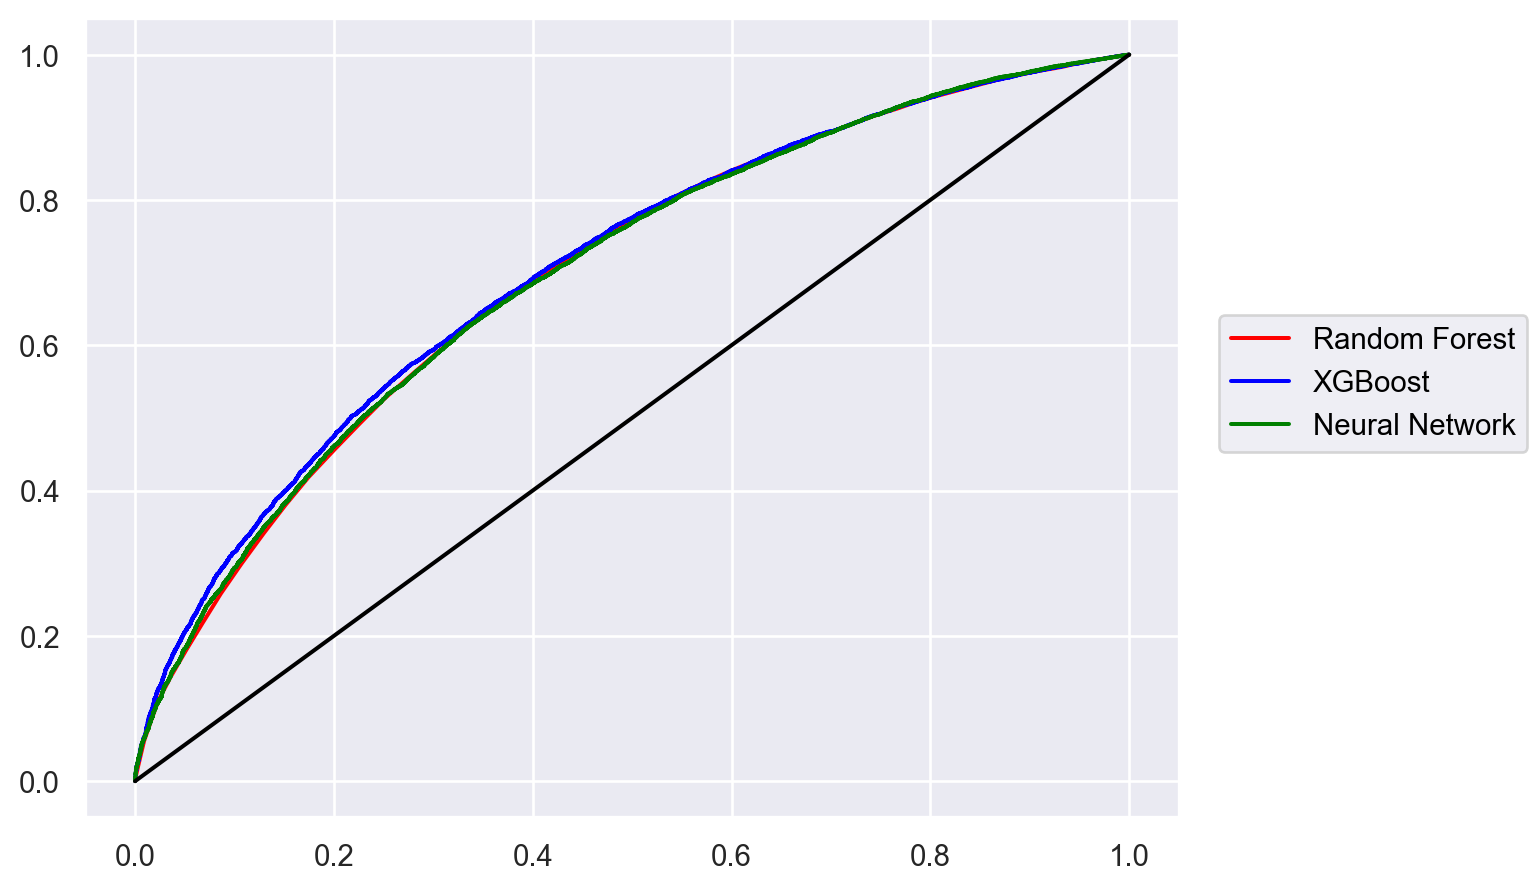

In [90]:
(so.Plot()
   .add(so.Line(color = 'red'),x = rf_fpr, y = rf_tpr, label="Random Forest")
   .add(so.Line(color = 'blue'),x = xgb_fpr, y = xgb_tpr, label="XGBoost")
   .add(so.Line(color = 'green'), x = ann_fpr, y = ann_tpr, label="Neural Network")
   .add(so.Line(color = 'black'),x = rf_fpr, y = rf_fpr)
)

If we look at the AUC score, the machine learning model with XGBoost has the highest AUC score. However, the AUC areas of these three models are extremely similar. So we need to look at it from another perspective. In the credit risk model, we really avoid false positive judgment, that is, we predict that the client will be successful in paying off the debt, but in fact, they will most likely be charged off. The XGBoost model has the lowest number of false positive judgments compared to the other two models based on the confusion matrix. Based on several sources, `AUC score = 0.7-0.8` can be considered `fair or acceptable`.